In [ ]:
#  multi-step encoder-decoder cnn-lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [1]:
# univariate multi-step encoder-decoder cnn-lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D



from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.models import load_model
from keras.models import load_model
import matplotlib.pyplot as plt

import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
# split a univariate dataset into train/test sets
#根据需求更改
#length分割长度
def split_dataset(train, test, length):
	# split into standard weeks
	#train, test = data[0:95016], data[95016:103776]
	# restructure into windows of 6hours data
	train = array(split(train, len(train)/length))
	test = array(split(test, len(test)/length))
	return train, test

In [3]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [4]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [5]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=6):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

In [6]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	#verbose, epochs, batch_size = 0, 1, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	#model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [7]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=1)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

In [8]:
# evaluate a single model
#def evaluate_model(train, test, n_input):
#更改函数返回值
def evaluate_model(train, test, n_input,model):
	# fit model
	#model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
        
	#score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return predictions, test[:, :, 0]

In [9]:
#只对train处理
dataset = read_csv('../data/selected_data_ISONE1.csv', header=0, infer_datetime_format=True, parse_dates=['date'], index_col=['date'])
data = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train, test = data[0:95016], data[95016:103776]
train = scaler.fit_transform(train)
test = scaler.transform(test)
length = 6
train, test = split_dataset(train, test, length)

n_input = 6

In [10]:
all_mae_histories = []
verbose, epochs, batch_size = 1, 1, 16
train_x, train_y = to_supervised(train, n_input)
model = build_model(train, n_input)
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# reshape output into [samples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
mae_history = history.history['loss']
all_mae_histories.append(mae_history)


file = open('history81.pkl', 'wb')
pickle.dump(all_mae_histories, file)
file.close()

model.save('model81.h5')

Epoch 1/1
94998/94998 [==============================] - 111s 1ms/step - loss: 0.0020


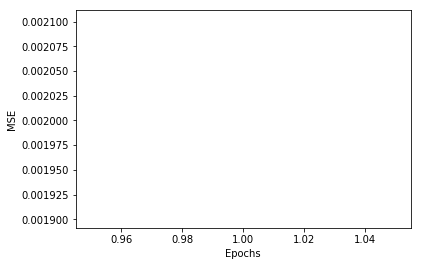

In [11]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [ ]:
#读取模型
model = load_model('model20193.h5')
file = open('history20193.pkl', 'rb')
load = pickle.load(file)

In [ ]:
#读取模型数据，画图
epochs = 3
average_mae_history = [
    np.mean([x[i] for x in load]) for i in range(epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [12]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# reshape output into [samples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
n_timesteps

12

In [13]:
n_outputs

6

In [14]:
n_features

2

In [15]:
pre, act = evaluate_model(train, test, n_input,model)

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


In [16]:
reshape_test = test.reshape([len(test)*length,2])
#去标准化，还原原值
inv_test = scaler.inverse_transform(reshape_test)

In [17]:
concat_test_pre = np.concatenate((pre.reshape([len(pre)*length,1]), test.reshape([len(test)*length,2])[:,-1 :]), axis=1)


In [18]:
concat_test_pre

array([[0.34765905, 0.25233645],
       [0.34386808, 0.24299065],
       [0.33667088, 0.22429907],
       ...,
       [0.40036479, 0.26168224],
       [0.33573982, 0.23364486],
       [0.27800274, 0.24299065]])

In [19]:
inv_test

array([[13821.,    20.],
       [13280.,    19.],
       [12885.,    17.],
       ...,
       [15525.,    21.],
       [14759.,    18.],
       [14071.,    19.]])

In [20]:
inv_testsplit = array(split(inv_test, len(inv_test)/length))
inv_testsplit

array([[[1.3821e+04, 2.0000e+01],
        [1.3280e+04, 1.9000e+01],
        [1.2885e+04, 1.7000e+01],
        [1.2729e+04, 1.7000e+01],
        [1.2779e+04, 1.7000e+01],
        [1.3137e+04, 1.7000e+01]],

       [[1.3633e+04, 1.7000e+01],
        [1.3968e+04, 1.7000e+01],
        [1.4498e+04, 1.7000e+01],
        [1.5023e+04, 1.9000e+01],
        [1.5407e+04, 2.2000e+01],
        [1.5614e+04, 2.3000e+01]],

       [[1.5671e+04, 2.4000e+01],
        [1.5548e+04, 2.5000e+01],
        [1.5505e+04, 2.6000e+01],
        [1.5735e+04, 2.6000e+01],
        [1.7002e+04, 2.5000e+01],
        [1.8231e+04, 2.4000e+01]],

       ...,

       [[1.4850e+04, 1.7000e+01],
        [1.5829e+04, 1.7000e+01],
        [1.6430e+04, 1.8000e+01],
        [1.6614e+04, 2.1000e+01],
        [1.6602e+04, 2.4000e+01],
        [1.6445e+04, 2.6000e+01]],

       [[1.6240e+04, 2.8000e+01],
        [1.6052e+04, 2.8000e+01],
        [1.5919e+04, 2.8000e+01],
        [1.6014e+04, 2.8000e+01],
        [1.7075e+04, 2.7000

In [21]:
inv_testsplit_0 = inv_testsplit[:, :, 0]
inv_testsplit_0

array([[13821., 13280., 12885., 12729., 12779., 13137.],
       [13633., 13968., 14498., 15023., 15407., 15614.],
       [15671., 15548., 15505., 15735., 17002., 18231.],
       ...,
       [14850., 15829., 16430., 16614., 16602., 16445.],
       [16240., 16052., 15919., 16014., 17075., 18123.],
       [17708., 16955., 16243., 15525., 14759., 14071.]])

In [22]:
inv_pre = scaler.inverse_transform(concat_test_pre)

In [23]:
inv_pre

array([[14687.38367152,    20.        ],
       [14612.21622682,    19.        ],
       [14469.51012039,    17.        ],
       ...,
       [15732.43298447,    21.        ],
       [14451.04917467,    18.        ],
       [13306.23830795,    19.        ]])

In [24]:
inv_presplit = array(split(inv_pre, len(inv_pre)/length))
inv_presplit

array([[[1.46873837e+04, 2.00000000e+01],
        [1.46122162e+04, 1.90000000e+01],
        [1.44695101e+04, 1.70000000e+01],
        [1.40664575e+04, 1.70000000e+01],
        [1.35664690e+04, 1.70000000e+01],
        [1.32020070e+04, 1.70000000e+01]],

       [[1.37595842e+04, 1.70000000e+01],
        [1.44324949e+04, 1.70000000e+01],
        [1.49045771e+04, 1.70000000e+01],
        [1.52133454e+04, 1.90000000e+01],
        [1.54254445e+04, 2.20000000e+01],
        [1.55584495e+04, 2.30000000e+01]],

       [[1.56401844e+04, 2.40000000e+01],
        [1.54541981e+04, 2.50000000e+01],
        [1.56368652e+04, 2.60000000e+01],
        [1.60608288e+04, 2.60000000e+01],
        [1.65377961e+04, 2.50000000e+01],
        [1.69215138e+04, 2.40000000e+01]],

       ...,

       [[1.50858596e+04, 1.70000000e+01],
        [1.62200499e+04, 1.70000000e+01],
        [1.68295891e+04, 1.80000000e+01],
        [1.71247822e+04, 2.10000000e+01],
        [1.71684039e+04, 2.40000000e+01],
        [1.7094

In [25]:
inv_presplit_0 = inv_presplit[:, :, 0]
inv_presplit_0

array([[14687.38367152, 14612.21622682, 14469.51012039, 14066.45746469,
        13566.46903682, 13202.00703192],
       [13759.584203  , 14432.49486351, 14904.57707322, 15213.34541678,
        15425.44449329, 15558.44945872],
       [15640.18439329, 15454.19809139, 15636.86519313, 16060.82875073,
        16537.79609978, 16921.51383841],
       ...,
       [15085.85964835, 16220.04990184, 16829.58907163, 17124.78219974,
        17168.40394723, 17094.87512493],
       [16382.13583529, 16163.67372739, 16280.57079232, 16686.66432464,
        17246.86222792, 17827.05865192],
       [18388.33025765, 17822.34665227, 16929.15266705, 15732.43298447,
        14451.04917467, 13306.23830795]])

In [26]:
score, scores = evaluate_forecasts(inv_testsplit_0, inv_presplit_0)
summarize_scores('lstm', score, scores)

lstm: [595.216] 316.6, 467.2, 470.7, 595.6, 693.8, 865.7
